In [1]:
%matplotlib widget
from ipywidgets import *
from astropy.io import fits
import astropy.time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv
import imutils
from scipy import ndimage

# Open the fits cube, lightcurve data and bad pixel map

## Fits cube

In [25]:
cube = fits.open('Data/Corrected_Data/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_SubArray_V0300.fits')
cube.info()

SubArray = cube[1].data
#MetaData = cube[9].data

cube.close()

Filename: Data/Corrected_Data/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_SubArray_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_COR_SubArray    1 ImageHDU       148   (200, 200, 224)   float64   
  2  SCI_COR_ImageMetadata    1 BinTableHDU    180   224R x 41C   [26A, 1D, 1D, 8A, 1E, 1E, 8A, 8A, 1E, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1I, 1B, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D]   
  3  PIP_COR_Centroid    1 BinTableHDU     95   224R x 9C   [26A, 1D, 1D, 1I, 1E, 1E, 1E, 1E, 1B]   
  4  SCI_COR_SmearingRow    1 ImageHDU        62   (200, 1, 224)   float64   
  5  SCI_COR_SmearingRowError    1 ImageHDU        62   (200, 1, 224)   float64   


## Lightcurve data

In [28]:
lightcurve = 'Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_Lightcurve-DEFAULT_V0300.fits'
lightcurve_file = fits.open(lightcurve)
lightcurve_data = lightcurve_file[1].data
lightcurve_header = lightcurve_file[1].header
lightcurve_file.close()

time = lightcurve_data['BJD_TIME']
roll_angle = lightcurve_data['ROLL_ANGLE']

## Bad pixel map

In [4]:
pixel_cube = fits.open('Data/visit_PR149000_TG009801/CH_TU2024-01-17T06-08-01_REF_APP_BadPixelMap_V0300.fits')
pixel_cube.info()
BadPixelMap = pixel_cube[1].data
pixel_cube.close()

Filename: Data/visit_PR149000_TG009801/CH_TU2024-01-17T06-08-01_REF_APP_BadPixelMap_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  REF_APP_BadPixelMap    1 ImageHDU        58   (1024, 1024)   int16   
  2  REF_APP_BadPixelMapLeft    1 ImageHDU        42   (16, 1024)   int16   
  3  REF_APP_BadPixelMapRight    1 ImageHDU        42   (16, 1024)   int16   
  4  REF_APP_BadPixelMapTop    1 ImageHDU        42   (1024, 3)   int16   
  5  REF_APP_PhotPixelMap    1 ImageHDU        35   (1024, 1024)   uint8   
  6  REF_APP_PhotPixelMapLeft    1 ImageHDU        36   (16, 1024)   uint8   
  7  REF_APP_PhotPixelMapRight    1 ImageHDU        36   (16, 1024)   uint8   
  8  REF_APP_PhotPixelMapTop    1 ImageHDU        36   (1024, 3)   uint8   


# Defining mean and median

In [5]:
median = np.median(SubArray[:,:,:], axis=0)
mean = np.mean(SubArray[:,:,:], axis=0)

# Make a histogram

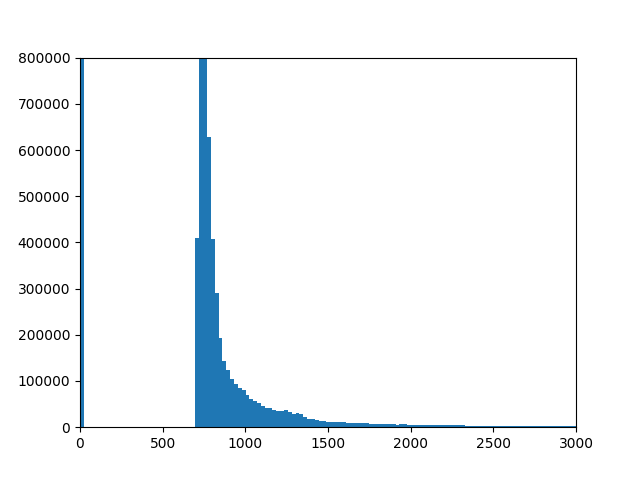

In [8]:
#reshape array from 3d to 2d
flattened_Array = np.ndarray.flatten(SubArray)
#plot a histogram
plt.figure()
plt.hist(flattened_Array, bins=800)
plt.ylim(top=0.8e6)
plt.xlim(left = 0, right=3000)
plt.show()

In [9]:
plt.close()

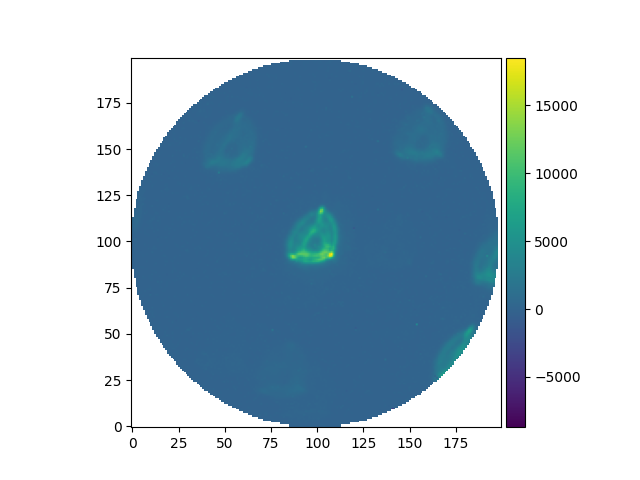

In [29]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(SubArray[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()

'''
axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 224, valstep=1)

def update(val):
    array = cube_mask[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()
slider.on_changed(update)
'''
plt.show()

In [11]:
plt.close()

# Create mask

In [30]:
mask = np.zeros(np.shape(median))
mask[median > 1300] = 1

kernel = np.ones((3,3), dtype=np.uint8)
enlarged_mask = cv.dilate(mask, kernel, iterations=1)

In [31]:
def apply_mask(data, mask):
    masked_cube = np.ma.masked_array(data, mask, fill_value=999999, hard_mask=True)
    return(masked_cube)

#im_cor_center = apply_mask(SubArray, enlarged_mask)
broadcast_mask = np.array(np.broadcast_to(enlarged_mask,np.shape(SubArray)), dtype='bool')

cube_mask = apply_mask(SubArray, broadcast_mask)

print(cube_mask[0,0,:])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 30.326066991265805
 -63.53333486670121 -77.3110410370617 -43.436979182106626
 -38.36150716721727 -33.804123196990304 -41.64262827496421
 63.19113215429496 -30.960283049260596 -30.73210597737949
 -22.460873242802847 -19.104660510140064 77.15942299985682
 -66.4608240920158 12.37517862550834 -24.003504510174196
 -51.100523032273486 -51.664479137068554 -- -- -- -59.968812587328415
 -21.392389465625428 -46.24555045917688 -56.911199742846264
 -6.620467280610484 -44.59400616757324 -50.11258616577746
 234.8794466898555 nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan 

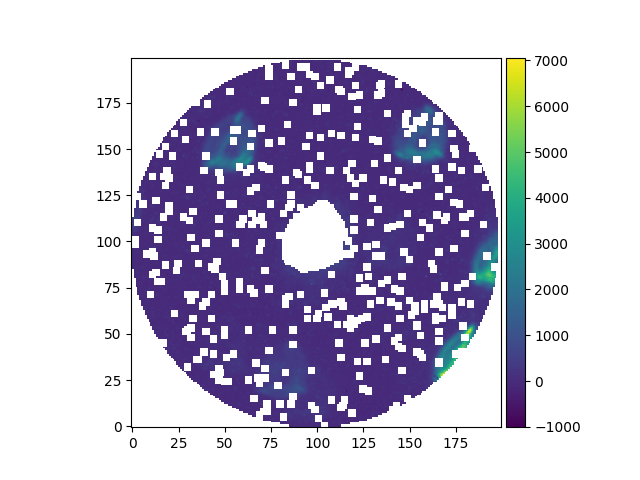

In [32]:
#plt.figure()
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(cube_mask[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()

'''
axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 224, valstep=1)

def update(val):
    array = cube_mask[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()
slider.on_changed(update)
'''
plt.show()

In [15]:
plt.close()

# Derotate image

In [37]:
def roll_angle_correction(data_array, roll_angle_array):
    rotated_array = np.empty(shape=(0,200,200))
    example_shape_array = np.empty(shape=(1,200,200))
    for i in range(20):
        rotated_image = np.full_like(example_shape_array,ndimage.rotate(data_array[i,:,:], -roll_angle_array[i], reshape=False))
        rotated_array = np.concatenate((rotated_array, rotated_image))
    
    print(rotated_array.shape)
    return(rotated_array)
        
derotated_cube = roll_angle_correction(SubArray, roll_angle)
print(derotated_cube.shape)

(20, 200, 200)
(20, 200, 200)


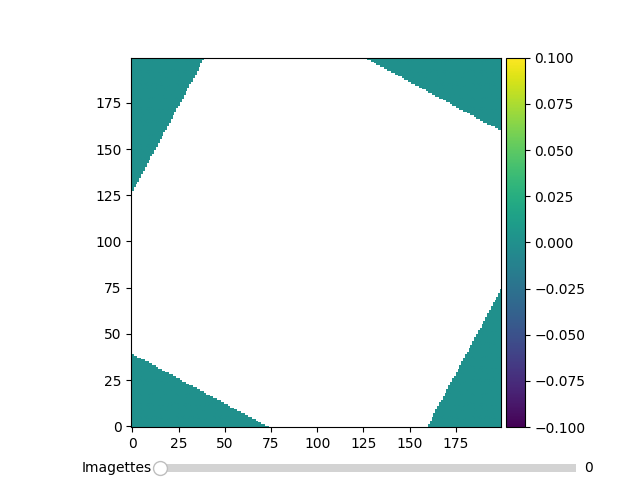

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(derotated_cube[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )
ax.invert_yaxis()


axslider = plt.axes([0.25, 0.01, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 20, valstep=1)

def update(val):
    array = derotated_cube[val,:,:]
    ax.imshow(array)
    ax.invert_yaxis()
slider.on_changed(update)

plt.show()

In [126]:
plt.close()